In [ ]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import io
import matplotlib
from IPython.display import display
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [ ]:
!gdown --id 1ti6QbZh_j9rh9fhKGZIoThM7FN9tF3Un #training data

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ti6QbZh_j9rh9fhKGZIoThM7FN9tF3Un
To: /content/labeled_data.csv
100% 2.57M/2.57M [00:00<00:00, 91.9MB/s]


In [ ]:
tweets = pd.read_csv("/content/labeled_data.csv")
tweets['class'] = tweets['class'].replace({2: 1})
display(tweets.head())
display(tweets.groupby("class").count())

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


,Unnamed: 0,count,hate_speech,offensive_language,neither,tweet
class,,,,,,
0,1430,1430,1430,1430,1430,1430
1,23353,23353,23353,23353,23353,23353


In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
nltk.download('punkt')
ps = PorterStemmer()
for i in range(len(tweets)):
  words = word_tokenize(tweets['tweet'][i])
  for j in range(len(words)):
    words[j] = ps.stem(words[j]) if words[j] not in set(all_stopwords) else ''
  tweets['tweet'][i] = ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
display(tweets.head())

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,1,! ! ! rt @ mayasolov : as woman n't complai...
1,1,3,0,3,0,1,! ! ! ! ! rt @ mleew17 : boy dat cold ... tyga...
2,2,3,0,3,0,1,! ! ! ! ! ! ! rt @ urkindofbrand dawg ! ! ! ! ...
3,3,3,0,2,1,1,! ! ! ! ! ! ! ! ! rt @ c_g_anderson : @ viva_b...
4,4,6,0,6,0,1,! ! ! ! ! ! ! ! ! ! ! ! ! rt @ shenikarobert :...


In [ ]:
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "") # remove URL protocol with trailing whitespace
    df[text_field] = df[text_field].str.replace(r"http", "") # remove URL protocol
    df[text_field] = df[text_field].str.replace(r"@\S+", "") # remove at signs with leading spaces 
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\n]", " ") # remove non-alphanumerical
    df[text_field] = df[text_field].str.replace(r"@", "at") # replace at signs with "at"
    df[text_field] = df[text_field].str.replace(r'\b\w{1,3}\b', '') # replace at words
    df[text_field] = df[text_field].str.replace(r'[0-9]', '') # replace at words
    df[text_field] = df[text_field].str.lower() # convert all to lowercase
    # df[text_field] = df[text_field].apply(lambda x: ''.join([stemmer.stem(y) for y in x]))
    return df

In [ ]:
# from nltk.stem import PorterStemmer
# from nltk.tokenize import word_tokenize
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# ps = PorterStemmer()
# def cleann(df,text_field):
#   df[text_field] = df[text_field].apply(lambda x: ''.join([ps.stem(y) for y in x]))
#   # xp = pd.DataFrame(df[text_field], columns=[text_field])
#   # df[text_field] = xp.text_field.apply([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text_field)])
#   return df

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# function to transform tweets to vectorized bag of word embedding
def vectorizer(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# set of all tweet text
# list_corpus = tweets["tweet"]
list_corpus = tweets[['class', 'tweet']]
# set of all tweet class labels
list_labels = tweets["class"].tolist()

# split into 80/20 train/test 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=69)

X_train = clean_text(X_train, "tweet")
# print(X_train)
# # X_train = cleann(X_train,'tweet')
# print(X_train)

# convert training and test set word to bag of words vectorized representation
X_train_counts, count_vectorizer = vectorizer(X_train['tweet'])
X_test_counts = count_vectorizer.transform(X_test['tweet'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
from sklearn.linear_model import LogisticRegression

# define logistic regression model 
clf = LogisticRegression()

# fit model on training data
model = clf.fit(X_train_counts, y_train)

# get model predictions on bag of words vectorized test data
y_predicted_counts = clf.predict(X_test_counts)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_np = clf.predict(X_test_counts)
cm = confusion_matrix(y_test, y_pred_np)
print(classification_report(y_test,y_pred_np))

              precision    recall  f1-score   support

           0       0.45      0.15      0.23       278
           1       0.95      0.99      0.97      4679

    accuracy                           0.94      4957
   macro avg       0.70      0.57      0.60      4957
weighted avg       0.92      0.94      0.93      4957



In [ ]:
def get_most_important_features(vectorizer, coefficients, n=20):
    
    # convert index of word from vectorizer into the word 
    index_to_word = {index:word for word,index in count_vectorizer.vocabulary_.items()}
    
    # assign coefficient to word by matching the index of the coefficient and word
    word_importances = [(coef, index_to_word[index]) for index, coef in enumerate(clf.coef_[0])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    # n = len(word_importances)//2
    # print(word_importances)
    p = []
    n = 0
    for x,y in sorted_coeff:
      if(x>=0):
        n+=1
      p.append(y)
    print(p)
    print(n)
    top = sorted(sorted_coeff[:20], key = lambda x : x)
    print(sorted_coeff[:n])
    print([y for x,y in sorted_coeff[:n]])

    print(len(set(word_importances)))
    bottom = sorted_coeff[-20:]
    print(sorted_coeff[n:])
    p= [y for x,y in sorted_coeff[n:]]
    print(p[::-1])
    print(len(p))
    classes = {
        'top':top,
        'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf.coef_)

['bird', 'charli', 'yanke', 'mock', 'side', 'actual', 'weekend', 'word', 'crazi', 'browni', 'femal', 'hair', 'great', 'point', 'bitch', 'yellow', 'pussi', 'lost', 'liberal', 'remind', 'mine', 'town', 'heydenbunsyolo', 'doubl', 'woman', 'kiss', 'weird', 'buck', 'jihadi', 'th', 'fruit', 'took', 'heat', 'hunter', 'grew', 'slope', 'long', 'hard', 'straight', 'smoke', 'twat', 'cultur', 'bout', 'loyal', 'officiallyic', 'dress', 'train', 'main', 'skinni', 'whole', 'hurt', 'tattoo', 'wonder', 'singl', 'ratchet', 'expect', 'everyon', 'tonight', 'fool', 'fell', 'ivanrabago', 'month', 'cool', 'brown', 'lgtwawmeh', 'song', 'juice', 'booti', 'brendagisselca', 'hashtag', 'oomf', 'world', 'imma', 'hole', 'detroit', 'random', 'told', 'less', 'gone', 'justcurrieon', 'money', 'facebook', 'slept', 'aunt', 'dare', 'ahead', 'shirt', 'about', 'major', 'matter', 'glad', 'didnt', 'messag', 'cuauhtli', 'hockey', 'zebra', 'wdnick', 'republican', 'slap', 'moemartin', 'land', 'luke', 'togeth', 'nobeeetch', 'curv'

In [ ]:
# for x in importance['bottom']:
#   print(x)

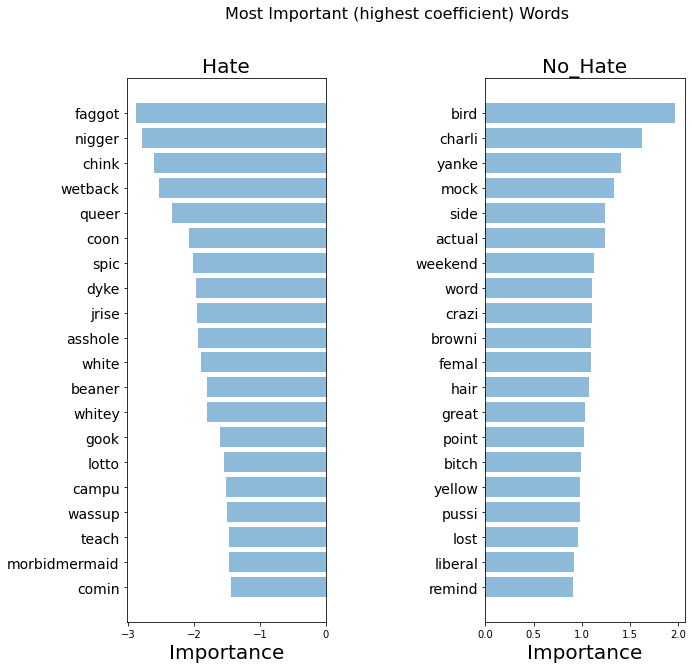

In [ ]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, title):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  
    
    # plot words with most negative coefficients (irrelevant words)
    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Hate', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    #plt.xlim(-8,0)
    
    # plot words with highest coefficients (relevant/disaster words)
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('No_Hate', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(title, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    #plt.xlim(0,8)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [word_score[0] for word_score in importance['top']]
top_words = [word_score[1] for word_score in importance['top']]
bottom_scores = [word_score[0] for word_score in importance['bottom']]
bottom_words = [word_score[1] for word_score in importance['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important (highest coefficient) Words")

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 30.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=878ba50409b4f4b3bc8f461e230f20c3e77326a65410977edd910036d6c940ed
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
# importing the libraries
import lime
import sklearn.ensemble
from __future__ import print_function
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

# converting the vectoriser and model into a pipeline
# this is necessary as LIME takes a model pipeline as an input
c = make_pipeline(count_vectorizer, model)

# saving a list of strings version of the X_test object
ls_X_test= list(X_test['tweet'])

# saving the class names in a dictionary to increase interpretability
class_names = {0: 'hate', 1:'No_hate'}

In [ ]:

# create the LIME explainer
# add the class names for interpretability
LIME_explainer = LimeTextExplainer(class_names=class_names)

# choose a random single prediction
idx = 126
# explain the chosen prediction 
# use the probability results of the logistic regression
# can also add num_features parameter to reduce the number of features explained
LIME_exp = LIME_explainer.explain_instance('fuck  i dont wan na watch tranni porn', c.predict_proba)
# print results
print('Document id: %d' % idx)
print('Tweet: ', ls_X_test[idx])
print('Probability disaster =', c.predict_proba([ls_X_test[idx]]).round(3)[0,1])
print('True class: %s' % class_names.get(list(y_test)[idx]))

Document id: 126
Tweet:  rt @ chrisjustjok : you got ta fuck ugli bitch  3 town    'll never see     work  kink    sex ga & # 8230 ;
Probability disaster = 0.975
True class: No_hate


In [ ]:

# print class names to show what classes the viz refers to
print("1 = No_Hate, 0 = Hate")
# show the explainability results with highlighted text
LIME_exp.show_in_notebook(text=True)

1 = No_Hate, 0 = Hate
